#### Setup

In [ ]:
! pip install transformers

In [ ]:
# Install Kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

In [3]:
import contextlib
from google.colab import files
import io

with contextlib.redirect_stdout(io.StringIO()):
    files.upload()

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c AI4Code

!  unzip /content/AI4Code.zip -d /content/data

! rm -rf /content/AI4Code.zip

### Imports and Globals

In [5]:
import json
from pathlib import Path
import os
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

pd.options.display.width = 180
pd.options.display.max_colwidth = 120

BERT_PATH = Path('/content/distil_bert_uncased')

os.makedirs(BERT_PATH, exist_ok=True)

data_dir = Path('/content/data')

### Read input data

In [6]:
NUM_TRAIN = 10000


def read_notebook(path):
    return (
        pd.read_json(
            path,
            dtype={'cell_type': 'category', 'source': 'str'})
        .assign(id=path.stem)
        .rename_axis('cell_id')
    )


paths_train = list((data_dir / 'train').glob('*.json'))[:NUM_TRAIN]
notebooks_train = [
    read_notebook(path) for path in tqdm(paths_train, desc='Train NBs')
]
df = (
    pd.concat(notebooks_train)
    .set_index('id', append=True)
    .swaplevel()
    .sort_index(level='id', sort_remaining=False)
)

df

Train NBs: 100%|██████████| 10000/10000 [00:39<00:00, 251.93it/s]


cell_type                                                                                                                   source
id             cell_id                                                                                                                                    
0001bdd4021779 3fdc37be      code  import pandas as pd\nimport numpy as np \nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport warnings as...
               073782ca      code                                                      df = pd.read_csv("/kaggle/input/us-police-shootings/shootings.csv")
               8ea7263c      code                                                                                                                df.head()
               80543cd8      code                                                                                                          df.isna().sum()
               38310c80      code                           sns.set()\nsns.countplot(df["gender"])\nplt.title("The Gender of Killed Person")\nplt.show()\n
...                           ...                                                                                                                      ...
fff6b47522f8b4 0f1eb6b3  markdown                                                                                  Visualize the postprocessing procedure:
               ee9b25e5  markdown  The following is my postprocessing procedure:\n1. First we remove the outliers by comparing each value to its runnin...
               6aec08d6  markdown  Procedure to produce floor results through KMeans+GBM @ https://www.kaggle.com/oxzplvifi/indoor-kmeans-gbm-floor-pre...
               729e716e  markdown              Compute running average on the magnetic field and interpolate into the wifi coordinates of the testing set:
               861380a8  markdown                     Thank you for reading! Let me know if you have any questions, and I look forward to any suggestions!

[458474 rows x 2 columns]

Let's analyse an example notebook.

* df created above contains all the commands (disordered)
* Order df (train_orders.csv) contains the order of the cells in the notebooks

In [7]:
nb_id = df.index.unique('id')[6]
print('Notebook:', nb_id)

print("The disordered notebook:")
nb = df.loc[nb_id, :]
display(nb)
print()

Notebook: 0023fe53ace4bb
The disordered notebook:


,cell_type,source
cell_id,,
0b04591a,code,%matplotlib inline\n\n\nimport pandas as pd\n\nbase_path = '../Backtests/'\n\nbm = 'SPXTR'\nbm_name = 'S&P 500 Total...
5214fe1e,code,import matplotlib\nimport matplotlib.pyplot as plt\nyr_periods = 252\n\n# Format for book display\nfont = {'family' ...
4287afca,code,"import empyrical as em\nfrom IPython.core.display import display, HTML\n\nmonthly_data = em.aggregate_returns(df[str..."
9fe41d6a,code,"def holding_period_map(df):\n yr = em.aggregate_returns(df[strat].pct_change(), 'yearly')\n df = pd.DataFrame(..."
d91114cd,code,import pandas as pd\nimport numpy as np\n\nbase_path = '../Backtests/'
de9c3eec,code,"# Rebalance on percent divergence\nclass PercentRebalance(object):\n def __init__(self, percent_target):\n ..."
06925db7,code,"\n# Calculate the rebalanced combination\ndef calc_rebalanced_returns(returns, rebalancer, weights):\n returns = ..."
8c8b5492,code,"# Use monthly rebalancer, one month interval\nrebalancer = MonthRebalance(1)\n\n# Define strategies and weights\npor..."
266ea54e,code,# Make Graph\nimport matplotlib \nimport matplotlib.pyplot as plt\n\ninclude_combined = True\ninclude_benchmark = Tr...


In [8]:
df_orders = pd.read_csv(
    data_dir / 'train_orders.csv',
    index_col='id',
    squeeze=True,
).str.split()  # Split the string representation of cell_ids into a list

df_orders

id
00001756c60be8    [1862f0a6, 448eb224, 2a9e43d6, 7e2f170a, 038b763d, 77e56113, 2eefe0ef, 1ae087ab, 0beab1cd, 8ffe0b25, 9a78ab76, 0d136...
00015c83e2717b    [2e94bd7a, 3e99dee9, b5e286ea, da4f7550, c417225b, 51e3cd89, 2600b4eb, 75b65993, cf195f8b, 25699d02, 72b3201a, f2c75...
0001bdd4021779    [3fdc37be, 073782ca, 8ea7263c, 80543cd8, 38310c80, 073e27e5, 015d52a4, ad7679ef, 7fde4f04, 07c52510, 0a1a7a39, 0bcd3...
0001daf4c2c76d    [97266564, a898e555, 86605076, 76cc2642, ef279279, df6c939f, 2476da96, 00f87d0a, ae93e8e6, 58aadb1d, d20b0094, 986fd...
0002115f48f982                                 [9ec225f0, 18281c6c, e3b6b115, 4a044c54, 365fe576, a3188e54, b3f6e12d, ee7655ca, 84125b7a]
                                                                           ...                                                           
fffc30d5a0bc46    [09727c0c, ff1ea6a0, ddfef603, a01ce9b3, 3ba953ee, bf92a015, f4a0492a, 095812e6, 53125cfe, aa32a700, 63340e73, 06d8c...
fffc3b44869198    [978a5137, fa

In [9]:
len(df_orders.loc[nb_id])

15

In [10]:
cell_order = df_orders.loc[nb_id]

print("The ordered notebook:")
nb.loc[cell_order, :]

The ordered notebook:


,cell_type,source
cell_id,,
4142961d,markdown,# 20 Performance Visualization and Combinations
46f9d46f,markdown,"The following code should run successfully on a local computer, but not here. The code is correct. Outputs are hidden."
37365702,markdown,# Model comparison
0b04591a,code,%matplotlib inline\n\n\nimport pandas as pd\n\nbase_path = '../Backtests/'\n\nbm = 'SPXTR'\nbm_name = 'S&P 500 Total...
5214fe1e,code,import matplotlib\nimport matplotlib.pyplot as plt\nyr_periods = 252\n\n# Format for book display\nfont = {'family' ...
4287afca,code,"import empyrical as em\nfrom IPython.core.display import display, HTML\n\nmonthly_data = em.aggregate_returns(df[str..."
9fe41d6a,code,"def holding_period_map(df):\n yr = em.aggregate_returns(df[strat].pct_change(), 'yearly')\n df = pd.DataFrame(..."
f0708bba,markdown,# Combined Models
d91114cd,code,import pandas as pd\nimport numpy as np\n\nbase_path = '../Backtests/'


Add rank to the cells in train_orders df

In [11]:
def get_ranks(base, derived):
    return [base.index(d) for d in derived]

# testing the function on the above example train_order sample
cell_ranks = get_ranks(cell_order, list(nb.index))
nb.insert(0, 'rank', cell_ranks)

nb

,rank,cell_type,source
cell_id,,,
0b04591a,3,code,%matplotlib inline\n\n\nimport pandas as pd\n\nbase_path = '../Backtests/'\n\nbm = 'SPXTR'\nbm_name = 'S&P 500 Total...
5214fe1e,4,code,import matplotlib\nimport matplotlib.pyplot as plt\nyr_periods = 252\n\n# Format for book display\nfont = {'family' ...
4287afca,5,code,"import empyrical as em\nfrom IPython.core.display import display, HTML\n\nmonthly_data = em.aggregate_returns(df[str..."
9fe41d6a,6,code,"def holding_period_map(df):\n yr = em.aggregate_returns(df[strat].pct_change(), 'yearly')\n df = pd.DataFrame(..."
d91114cd,8,code,import pandas as pd\nimport numpy as np\n\nbase_path = '../Backtests/'
de9c3eec,9,code,"# Rebalance on percent divergence\nclass PercentRebalance(object):\n def __init__(self, percent_target):\n ..."
06925db7,10,code,"\n# Calculate the rebalanced combination\ndef calc_rebalanced_returns(returns, rebalancer, weights):\n returns = ..."
8c8b5492,11,code,"# Use monthly rebalancer, one month interval\nrebalancer = MonthRebalance(1)\n\n# Define strategies and weights\npor..."
266ea54e,12,code,# Make Graph\nimport matplotlib \nimport matplotlib.pyplot as plt\n\ninclude_combined = True\ninclude_benchmark = Tr...


Assign correct cell order rank in the df created from raw data

In [12]:
# Step 1 : Add correct cell order to df, using order in df_orders 
df_orders_ = df_orders.to_frame().join(
    df.reset_index('cell_id').groupby('id')['cell_id'].apply(list),
    how='right',
)

# Step 2 - Get rank (here cell_order is base and cell_id retreived from df_orders is the derived)
ranks = {}
for id_, cell_order, cell_id in df_orders_.itertuples():
    ranks[id_] = {'cell_id': cell_id, 'rank': get_ranks(cell_order, cell_id)}

# Step 3 - Create a dataframe out of it
df_ranks = (
    pd.DataFrame
    .from_dict(ranks, orient='index')
    .rename_axis('id')
    .apply(pd.Series.explode)
    .set_index('cell_id', append=True)
)

df_ranks

rank
id             cell_id      
0001bdd4021779 3fdc37be    0
               073782ca    1
               8ea7263c    2
               80543cd8    3
               38310c80    4
...                      ...
fff6b47522f8b4 0f1eb6b3   20
               ee9b25e5   18
               6aec08d6    6
               729e716e    8
               861380a8   25

[458474 rows x 1 columns]

Read in ancestors data

In [13]:
df_ancestors = pd.read_csv(data_dir / 'train_ancestors.csv', index_col='id')
df_ancestors

,ancestor_id,parent_id
id,,
00001756c60be8,945aea18,NaN
00015c83e2717b,aa2da37e,317b65d12af9df
0001bdd4021779,a7711fde,NaN
0001daf4c2c76d,090152ca,NaN
0002115f48f982,272b483a,NaN
...,...,...
fffc30d5a0bc46,6aed207b,NaN
fffc3b44869198,a6aaa8d7,NaN
fffc63ff750064,0a1b5b65,NaN


Merge ranks and ancestors to raw data

In [14]:
df = df.reset_index().merge(df_ranks, on=["id", "cell_id"]).merge(df_ancestors, on=["id"])
df

,id,cell_id,cell_type,source,rank,ancestor_id,parent_id
0,0001bdd4021779,3fdc37be,code,import pandas as pd\nimport numpy as np \nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport warnings as...,0,a7711fde,NaN
1,0001bdd4021779,073782ca,code,"df = pd.read_csv(""/kaggle/input/us-police-shootings/shootings.csv"")",1,a7711fde,NaN
2,0001bdd4021779,8ea7263c,code,df.head(),2,a7711fde,NaN
3,0001bdd4021779,80543cd8,code,df.isna().sum(),3,a7711fde,NaN
4,0001bdd4021779,38310c80,code,"sns.set()\nsns.countplot(df[""gender""])\nplt.title(""The Gender of Killed Person"")\nplt.show()\n",4,a7711fde,NaN
...,...,...,...,...,...,...,...
458469,fff6b47522f8b4,0f1eb6b3,markdown,Visualize the postprocessing procedure:,20,3ef2da49,NaN
458470,fff6b47522f8b4,ee9b25e5,markdown,The following is my postprocessing procedure:\n1. First we remove the outliers by comparing each value to its runnin...,18,3ef2da49,NaN
458471,fff6b47522f8b4,6aec08d6,markdown,Procedure to produce floor results through KMeans+GBM @ https://www.kaggle.com/oxzplvifi/indoor-kmeans-gbm-floor-pre...,6,3ef2da49,NaN
458472,fff6b47522f8b4,729e716e,markdown,Compute running average on the magnetic field and interpolate into the wifi coordinates of the testing set:,8,3ef2da49,NaN


Is there any data skew?

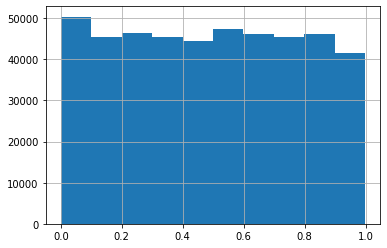

In [15]:
df["pct_rank"] = df["rank"] / df.groupby("id")["cell_id"].transform("count")

df["pct_rank"].hist(bins=10)

Doesn't look it!

Train-Valid Split

Since we want the entire notebook to be in either train or test split (or validation), we can use GroupShuffleSplit, using ancestor_id as per the data documentation

In [16]:
from sklearn.model_selection import GroupShuffleSplit

NVALID = 0.1  # size of validation set

splitter = GroupShuffleSplit(n_splits=1, test_size=NVALID, random_state=0)

train_ind, val_ind = next(splitter.split(df, groups=df["ancestor_id"]))

train_df = df.loc[train_ind].reset_index(drop=True)
val_df = df.loc[val_ind].reset_index(drop=True)

In [17]:
val_df.head()

,id,cell_id,cell_type,source,rank,ancestor_id,parent_id,pct_rank
0,0023fe53ace4bb,0b04591a,code,%matplotlib inline\n\n\nimport pandas as pd\n\nbase_path = '../Backtests/'\n\nbm = 'SPXTR'\nbm_name = 'S&P 500 Total...,3,350545d2,105b5ed04f3dbc,0.2
1,0023fe53ace4bb,5214fe1e,code,import matplotlib\nimport matplotlib.pyplot as plt\nyr_periods = 252\n\n# Format for book display\nfont = {'family' ...,4,350545d2,105b5ed04f3dbc,0.266667
2,0023fe53ace4bb,4287afca,code,"import empyrical as em\nfrom IPython.core.display import display, HTML\n\nmonthly_data = em.aggregate_returns(df[str...",5,350545d2,105b5ed04f3dbc,0.333333
3,0023fe53ace4bb,9fe41d6a,code,"def holding_period_map(df):\n yr = em.aggregate_returns(df[strat].pct_change(), 'yearly')\n df = pd.DataFrame(...",6,350545d2,105b5ed04f3dbc,0.4
4,0023fe53ace4bb,d91114cd,code,import pandas as pd\nimport numpy as np\n\nbase_path = '../Backtests/',8,350545d2,105b5ed04f3dbc,0.533333


In [18]:
val_df["cell_type"].value_counts()

code        29582
markdown    15207
Name: cell_type, dtype: int64

In [19]:
train_df_mark = train_df[train_df["cell_type"] == "markdown"].reset_index(drop=True)

val_df_mark = val_df[val_df["cell_type"] == "markdown"].reset_index(drop=True)

### Competition Metrics

In [20]:
from bisect import bisect


def count_inversions(a):
    inversions = 0
    sorted_so_far = []
    for i, u in enumerate(a):
        j = bisect(sorted_so_far, u)
        inversions += i - j
        sorted_so_far.insert(j, u)
    return inversions


def kendall_tau(ground_truth, predictions):
    total_inversions = 0
    total_2max = 0  # twice the maximum possible inversions across all instances
    for gt, pred in zip(ground_truth, predictions):
        ranks = [gt.index(x) for x in pred]  # rank predicted order in terms of ground truth
        total_inversions += count_inversions(ranks)
        n = len(gt)
        total_2max += n * (n - 1)
    return 1 - 4 * total_inversions / total_2max

Test out the metrics on example

In [21]:
y_dummy = val_df.groupby('id')['cell_id'].apply(list)
kendall_tau(df_orders.loc[y_dummy.index], y_dummy)

0.39922830525018216

### Modelling

#### Download and Save Distil-BERT model

In [22]:
from transformers import DistilBertTokenizer, DistilBertModel
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

tokenizer.save_pretrained(BERT_PATH)
model.save_pretrained(BERT_PATH)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Modelling imports and globals

In [23]:
from tqdm import tqdm
import sys, os
from transformers import DistilBertModel, DistilBertTokenizer
import torch.nn.functional as F
import torch.nn as nn
import torch

MAX_LEN = 128

In [24]:
class MarkdownModel(nn.Module):
    def __init__(self):
        super(MarkdownModel, self).__init__()
        self.distill_bert = DistilBertModel.from_pretrained(BERT_PATH)
        self.top = nn.Linear(768, 1)
        
    def forward(self, ids, mask):
        x = self.distill_bert(ids, mask)[0]
        x = self.top(x[:, 0, :])
        return x

In [25]:
from torch.utils.data import DataLoader, Dataset


class MarkdownDataset(Dataset):
    '''
    Child DataSet class updating __getitem__ of the df and 
    replacing it to return Token ids, attention masks and percent rank
    '''
    
    def __init__(self, df, max_len):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.max_len = max_len
        self.tokenizer = DistilBertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)

    def __getitem__(self, index):
        '''
        So, when we say data[1], the MarkdownDataset will return 
        Token ids, attention masks and percent rank of the index 1
        '''
        row = self.df.iloc[index]
        
        inputs = self.tokenizer.encode_plus(
            row.source,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = torch.LongTensor(inputs['input_ids'])
        mask = torch.LongTensor(inputs['attention_mask'])

        return ids, mask, torch.FloatTensor([row.pct_rank])

    def __len__(self):
        return self.df.shape[0]

In [26]:
train_ds = MarkdownDataset(train_df_mark, max_len=MAX_LEN)
val_ds = MarkdownDataset(val_df_mark, max_len=MAX_LEN)

val_ds[0]

(tensor([ 101, 1001, 4117, 4275,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Adjusted Learning Rate and Optimizer

In [27]:
def adjust_lr(optimizer, epoch):
    if epoch < 1:
        lr = 5e-5
    elif epoch < 2:
        lr = 1e-3
    elif epoch < 5:
        lr = 1e-4
    else:
        lr = 1e-5

    for p in optimizer.param_groups:
        p['lr'] = lr
    return lr
    
def get_optimizer(net):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=3e-4, betas=(0.9, 0.999),
                                 eps=1e-08)
    return optimizer

Create batched data using DataLoader API

In [28]:
BS = 32
NW = 8

train_loader = DataLoader(train_ds, batch_size=BS, shuffle=True, num_workers=NW,
                          pin_memory=False, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=BS, shuffle=False, num_workers=NW,
                          pin_memory=False, drop_last=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Define the training loop

In [29]:
def read_data(data):
    '''
    read features and labels
    '''
    return tuple(d.cuda() for d in data[:-1]), data[-1].cuda()


def validate(model, val_loader):
    model.eval()
    
    tbar = tqdm(val_loader, file=sys.stdout)
    
    preds = []
    labels = []

    with torch.no_grad():
        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)

            pred = model(inputs[0], inputs[1])

            preds.append(pred.detach().cpu().numpy().ravel())
            labels.append(target.detach().cpu().numpy().ravel())
    
    return np.concatenate(labels), np.concatenate(preds)

def train(model, train_loader, val_loader, epochs):
    np.random.seed(0)
    # Initialize optimizer
    optimizer = get_optimizer(model)
    # Initialize metric
    criterion = torch.nn.MSELoss()
    
    for e in range(epochs):
        # Start the training loop   
        model.train()
        tbar = tqdm(train_loader, file=sys.stdout)
        
        # Adjusted Learning Rate
        lr = adjust_lr(optimizer, e)
        
        loss_list = []
        preds = []
        labels = []

        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)

            # Recycle gradients
            optimizer.zero_grad()
            # Get model outputs
            pred = model(inputs[0], inputs[1])
            # Calculate loss
            loss = criterion(pred, target)
            loss.backward()
            # Complete optimizer step
            optimizer.step()
            
            # Append loss, predictions and labels
            loss_list.append(loss.detach().cpu().item())
            preds.append(pred.detach().cpu().numpy().ravel())
            labels.append(target.detach().cpu().numpy().ravel())
            
            # Get average loss for the training loop
            avg_loss = np.round(np.mean(loss_list), 4)

            tbar.set_description(f"Epoch {e+1} Loss: {avg_loss} lr: {lr}")
            
        y_val, y_pred = validate(model, val_loader)
            
        print("Validation MSE:", np.round(mean_squared_error(y_val, y_pred), 4))
        print()
    return model, y_pred

model = MarkdownModel()
model = model.cuda()
model, y_pred = train(model, train_loader, val_loader, epochs=1)

  0%|          | 0/4359 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 476/476 [01:08<00:00,  6.96it/s]
Validation MSE: 0.054



Add Predictions to Validation df

In [39]:
val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred

In [40]:
val_df.head()

,id,cell_id,cell_type,source,rank,ancestor_id,parent_id,pct_rank,pred
0,0023fe53ace4bb,0b04591a,code,%matplotlib inline\n\n\nimport pandas as pd\n\nbase_path = '../Backtests/'\n\nbm = 'SPXTR'\nbm_name = 'S&P 500 Total...,3,350545d2,105b5ed04f3dbc,0.2,0.090909
1,0023fe53ace4bb,5214fe1e,code,import matplotlib\nimport matplotlib.pyplot as plt\nyr_periods = 252\n\n# Format for book display\nfont = {'family' ...,4,350545d2,105b5ed04f3dbc,0.266667,0.181818
2,0023fe53ace4bb,4287afca,code,"import empyrical as em\nfrom IPython.core.display import display, HTML\n\nmonthly_data = em.aggregate_returns(df[str...",5,350545d2,105b5ed04f3dbc,0.333333,0.272727
3,0023fe53ace4bb,9fe41d6a,code,"def holding_period_map(df):\n yr = em.aggregate_returns(df[strat].pct_change(), 'yearly')\n df = pd.DataFrame(...",6,350545d2,105b5ed04f3dbc,0.4,0.363636
4,0023fe53ace4bb,d91114cd,code,import pandas as pd\nimport numpy as np\n\nbase_path = '../Backtests/',8,350545d2,105b5ed04f3dbc,0.533333,0.454545


Calculate Score based on Kendall-Tau Coefficient

In [41]:
y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
kendall_tau(df_orders.loc[y_dummy.index], y_dummy)

0.7422567030670741

74% Validation Accuracy on 1 epoch and 10K notebooks is pretty impressive!